#### Things to add on:
* graphs to illustrate the differences in the sampling methods

# Using Logistic Regression with Oversampling

In this notebook, I'll be analyzing this dataset with the Logistic Regression model. Due to the imbalance of the dataset, I'll be using and comparing a few oversampling methods to deal with this imbalance issue.

In [1]:
import pandas as pd
df = pd.read_csv('data/res_anon_working.csv')

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, average_precision_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

/Users/yuanbo/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,Class
0,4,0.0,1.0,48.0,3,0,0,1,0,0,0,0,1,0,1,0,0,0.0,7.138867,0.0
1,7,0.0,1.0,125.0,3,0,1,1,0,0,0,0,0,0,0,0,0,0.0,7.138867,0.0
2,2,0.0,1.0,14.0,3,0,0,1,0,0,0,0,1,0,1,0,0,0.0,7.727535,0.0
3,3,0.0,1.0,67.0,2,0,1,1,0,1,0,0,0,0,0,1,0,0.0,7.727535,0.0
4,5,0.0,1.0,117.0,2,0,0,1,0,0,0,1,0,0,0,0,0,0.0,7.727535,0.0


#### Defining X and y

In [4]:
feat_lst = list(df)
feat_lst.pop(-1)
feat_lst

['F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'F9',
 'F10',
 'F11',
 'F12',
 'F13',
 'F14',
 'F15',
 'F16',
 'F17',
 'F18',
 'F19']

In [5]:
X = df[feat_lst]
y = df['Class']

#### Looking at the data imbalance

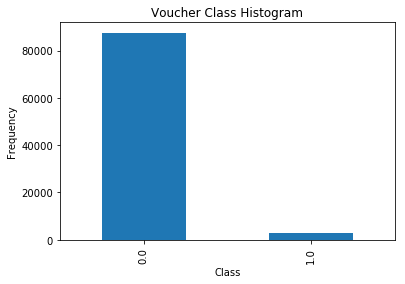

In [6]:
count_classes = pd.value_counts(df['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Voucher Class Histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

As you can see, the data is hugely imbalanced, which will affect our model accuracy greatly. But let's proceed without any resampling of data to see where this goes

#### Defining model evaluation functions

In [7]:
def model_eval(X, y, model):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(confusion_matrix(y, y_pred))
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    print('Precision: %f' % (float(tp)/(tp + fp)))
    print('Recal: %f' % (float(tp)/(tp + fn)))
    y_proba = model.predict_proba(X)[:,1]
    print('AUC: %f' % roc_auc_score(y, y_proba))

# AUC under ROC curve should be using the probabilities of each sample instead of the actual label for each sample
# Hence, it must be using predict_proba and not predict

In [8]:
def graph_eval(X, y, model):
    p_range = np.arange(0.1, 1, 0.1) 
    p_range
    precisions = []
    recalls = []
    f1s = []
    prob_range = []
    model.fit(X, y)

    pred = model.predict_proba(X)
    for p in p_range:

        pred_tmp = pred[:, 1].copy()
        pred_tmp[pred_tmp > p] = 1
        pred_tmp[pred_tmp <= p] = 0
        tn, fp, fn, tp = confusion_matrix(y, pred_tmp).ravel()
        if tp == 0: 
            continue
        prec = (float(tp)/(tp + fp))
        rec = (float(tp)/(tp + fn))
        f1 = 2 * prec * rec / (prec + rec)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
        prob_range.append(p)

    # plot the results
    plt.plot(prob_range, precisions, 'k', label='Precision')
    plt.plot(prob_range, recalls, 'g', label='Recall')
    plt.plot(prob_range, f1s, 'b', label='F1')
    plt.xlabel('Prob Range')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1))

#### Fitting and testing out the model without any resampling of data

In [9]:
logreg = LogisticRegression(C=1e9) 
logreg.fit(X, y)
y_proba = logreg.predict_proba(X)[:,1]
# model.predict returns an array of predicted labels of each sample, so it shows either 0 or 1 for each sample
# model.predict_proba returns an array of the probabilities that each sample is a 0 or 1
# [:,1] means only display the probability that the sample is a 1
y_proba

array([ 0.07440339,  0.04609035,  0.069266  , ...,  0.00611089,
        0.00554817,  0.00554775])

In [10]:
model_eval(X, y, logreg)

[[87558     0]
 [ 2874     0]]
Accuracy: 96.82%


ZeroDivisionError: float division by zero

As you can see, I received a zero error for the precision metric because both true positive and false positive are 0. Essentially, the logistic regression model simply predicted all negatives as a result of the huge data imbalance. Even if we receive a high accuracy of 96.82%, this model is still horrible as it classifies all the '1' incorrectly as '0'.

### Let's look at some oversampling methods
* Naive Oversampling
* Synthetic Minority Oversampling Technique (SMOTE)
* Adaptive Synthetic Oversampling (ADASYN)

## Naive Random Oversampling

In [11]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
ros = RandomOverSampler(random_state=0)
X_ros_resampled, y_ros_resampled = ros.fit_sample(X, y)
from collections import Counter
print sorted(Counter(y_ros_resampled).items())

[(0.0, 87558), (1.0, 87558)]


#### Splitting data into train and test set. Cross validation will be used when calculating evaluating metrics.

In [12]:
X_ros_resampled_train, X_ros_resampled_test, y_ros_resampled_train, y_ros_resampled_test = train_test_split(X_ros_resampled, y_ros_resampled, test_size=0.33, random_state=0)

#### Fitting, training and evaluating the model

In [13]:
logreg = LogisticRegression(C=1e9) 
logreg.fit(X_ros_resampled_train, y_ros_resampled_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

[[16546 12090]
 [11181 17972]]
Accuracy: 59.73%
Precision: 0.597831
Recal: 0.616472
AUC: 0.641291


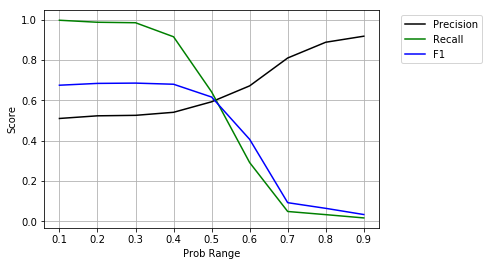

In [14]:
model_eval(X_ros_resampled_test, y_ros_resampled_test, logreg)
graph_eval(X_ros_resampled_test, y_ros_resampled_test, logreg)

## Oversampling using SMOTE

In [15]:
X_smote_resampled, y_smote_resampled = SMOTE().fit_sample(X, y)
print sorted(Counter(y_smote_resampled).items())

[(0.0, 87558), (1.0, 87558)]


#### Splitting data into train and test set. Cross validation will be used when calculating evaluating metrics.

In [16]:
X_smote_resampled_train, X_smote_resampled_test, y_smote_resampled_train, y_smote_resampled_test = train_test_split(X_smote_resampled, y_smote_resampled, test_size=0.33, random_state=0)

#### Fitting, training and evaluating the model

In [17]:
logreg = LogisticRegression(C=1e9) 
logreg.fit(X_smote_resampled_train, y_smote_resampled_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

[[16627 12009]
 [11145 18008]]
Accuracy: 59.93%
Precision: 0.599927
Recal: 0.617707
AUC: 0.648269


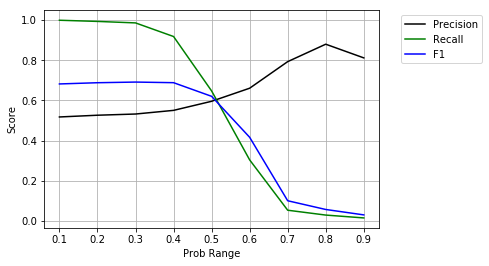

In [18]:
model_eval(X_smote_resampled_test, y_smote_resampled_test, logreg)
graph_eval(X_smote_resampled_test, y_smote_resampled_test, logreg)

## Oversampling using ADASYN

In [19]:
X_adasyn_resampled, y_adasyn_resampled = ADASYN().fit_sample(X, y)
print sorted(Counter(y_adasyn_resampled).items())

[(0.0, 87558), (1.0, 88092)]


#### Splitting data into train and test set. Cross validation will be used when calculating evaluating metrics.

In [20]:
X_adasyn_resampled_train, X_adasyn_resampled_test, y_adasyn_resampled_train, y_adasyn_resampled_test = train_test_split(X_adasyn_resampled, y_adasyn_resampled, test_size=0.33, random_state=0)

#### Fitting, training and evaluating the model

In [21]:
logreg = LogisticRegression(C=1e9) 
logreg.fit(X_adasyn_resampled_train, y_adasyn_resampled_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

[[17933 10657]
 [ 9708 19667]]
Accuracy: 64.87%
Precision: 0.648562
Recal: 0.669515
AUC: 0.698894


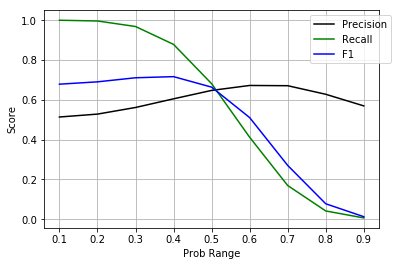

In [22]:
model_eval(X_adasyn_resampled_test, y_adasyn_resampled_test, logreg)
graph_eval(X_adasyn_resampled_test, y_adasyn_resampled_test, logreg)

Looks like there's not much difference between all 3 oversampling methods, though ADASYN yielded the best results shown above. I'll explore using undersampling techniques in another notebook.